In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [161]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import confusion_matrix
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Importing keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
np.random.seed(7)

# Test metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification-new/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Pre-processing of data for training the model (Amazon dataset)

### Import training data

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect(COLAB_FILEPATH + 'data/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [ ]:
data_train_raw_.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
data_train_raw_.shape

(568454, 10)

# Filtering of the train data

### Remove duplicate entries

In [ ]:
# check duplication of an entry
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
#Sorting data according to ProductId in ascending order
data_train_raw=data_train_raw_.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
# remove duplication of entries
data_train_raw=data_train_raw.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data_train_raw.shape

(393933, 10)

In [ ]:
data_train_raw.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [ ]:
# Checking to see how much % of data still remains
(data_train_raw['Id'].size*1.0)/(data_train_raw_['Id'].size*1.0)*100

69.29901100176971

In [ ]:
# sample query
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
# choose data that the helpfulness numerator is higher than the denominator
data_train_raw=data_train_raw[data_train_raw.HelpfulnessNumerator<=data_train_raw.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_train_raw.shape)

# distribution of the score of the train data
data_train_raw['Score'].value_counts()

(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

### Create a training dataframe with only the comments and the ratings

In [ ]:
# create an empty dataframe
data_train = pd.DataFrame()

# to store only the required columns into the new dataframe
data_train['comments'] = data_train_raw['Text']
data_train['ratings'] = data_train_raw['Score']
data_train['type'] = "train"
data_train.head()

,comments,ratings,type
150528,In June<br />I saw a charming group<br />of ro...,4,train
150506,This is a fun way for children to learn their ...,4,train
150505,"I grew up reading these Sendak books, and watc...",4,train
150504,Get the movie or sound track and sing along wi...,4,train
150503,A very entertaining rhyming story--cleaver and...,4,train


In [ ]:
data_train.shape

(393931, 3)

In [ ]:
data_train.dtypes

comments    object
ratings      int64
type        object
dtype: object

There are 393931 data that we will use to train and validate our model, now we will move on to pre-process our test data, which was scraped from trip advisor.

# Pre-processing the test set (scraped data from tripadvisor)
The goal is to clean the data of the test set so that the both datasets have the same columns

### Import test data

In [ ]:
# read the test data
data_test_raw_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
data_test_raw_.head()

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...
3,Positano @ RP,"Italian, European",Amaliamazlan,5,Not my first time in Positano and definitely w...
4,Positano @ RP,"Italian, European",Shahzanstim,5,Excellent service from the staff. The beef was...


In [ ]:
data_test_raw_.shape

(97190, 5)

### Filtering of the test data

In [ ]:
# remove duplication of entries
data_test_raw=data_test_raw_.drop_duplicates(subset={"Reviewer\'s Name","Comment"}, keep='first', inplace=False)
data_test_raw.shape

(88042, 5)

In [ ]:
data_test_raw.head(3)

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...


In [ ]:
#Checking to see how much % of data still remains after removing duplications
(data_test_raw['Reviewer\'s Name'].size*1.0)/(data_test_raw_['Reviewer\'s Name'].size*1.0)*100

90.58750900298385

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_test_raw.shape)

# distribution of the score of the test data
data_test_raw['Rating'].value_counts()

(88042, 5)


5    46304
4    25976
3     8837
1     3464
2     3461
Name: Rating, dtype: int64

### Create a test dataframe with only the comments and the ratings

In [ ]:
# create an empty dataframe
data_test = pd.DataFrame()

# to store only the required columns into the new dataframe
data_test['comments'] = data_test_raw['Comment']
data_test['ratings'] = data_test_raw['Rating']
data_test['type'] = "test"
data_test.head()

,comments,ratings,type
0,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Wonderful and amazing service experience. Defi...,5,test
2,Great food and wonderful service! Will definit...,5,test
3,Not my first time in Positano and definitely w...,5,test
4,Excellent service from the staff. The beef was...,5,test


In [ ]:
data_test.shape

(88042, 3)

In [ ]:
data_test.dtypes

comments    object
ratings      int64
type        object
dtype: object

# Partition the ratings to 3 classes only
-1 (negative) <- 1,2  
0 (neutral) <- 3  
1 (positive) <- 4,5


In [ ]:
def partition(x):
    if x < 3:
        return -1
    elif x == 3:
        return 0
    else:   
        return 1

In [ ]:
# append partitioned data to the train set
actualScore = data_train['ratings']
class_ = actualScore.map(partition) 
data_train['ratings_class'] = class_
print("Number of data points in our data", data_train.shape)
data_train.head(3)

Number of data points in our data (393931, 4)


,comments,ratings,type,ratings_class
150528,In June<br />I saw a charming group<br />of ro...,4,train,1
150506,This is a fun way for children to learn their ...,4,train,1
150505,"I grew up reading these Sendak books, and watc...",4,train,1


In [ ]:
data_train.dtypes

comments         object
ratings           int64
type             object
ratings_class     int64
dtype: object

In [ ]:
# append partitioned data to the test set
actualScore = data_test['ratings']
class_ = actualScore.map(partition) 
data_test['ratings_class'] = class_
print("Number of data points in our data", data_test.shape)
data_test.head(3)

Number of data points in our data (88042, 4)


,comments,ratings,type,ratings_class
0,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Wonderful and amazing service experience. Defi...,5,test,1
2,Great food and wonderful service! Will definit...,5,test,1


In [ ]:
data_test.dtypes

comments         object
ratings           int64
type             object
ratings_class     int64
dtype: object

# Downsampling the train data
because there is a data imbalance in the the train set

In [ ]:
data_train['ratings_class'].value_counts()

 1    307052
-1     57107
 0     29772
Name: ratings_class, dtype: int64

data with class 0 has the smallest count

splitting the data

In [ ]:
# data with class 0
data_0 = data_train[data_train['ratings_class'] == 0]
print(data_0.shape)
data_0.head(3)

(29772, 4)


,comments,ratings,type,ratings_class
150494,When I ordered a large amount of these books t...,3,train,0
150527,This book was purchased to be used in a classr...,3,train,0
150526,"It was a great price, but I can't read it to m...",3,train,0


In [ ]:
# data with class -1, sample with the total number of entries in class 0
data_minus_1 = data_train[data_train['ratings_class'] == -1].sample(len(data_0), replace=False)
print(data_minus_1.shape)
data_minus_1.head(3)

(29772, 4)


,comments,ratings,type,ratings_class
421898,"THIS HAZELNUT BUTTER TASTES GOOD, PARTICULARL...",2,train,-1
83667,"I'm all for eco-friendlier packaging, but this...",1,train,-1
376076,The Cinnamon Raisin sounded so good. Not so mu...,1,train,-1


In [ ]:
# data with class -1, sample with the total number of entries in class 0
data_1 = data_train[data_train['ratings_class'] == 1].sample(len(data_0), replace=False)
print(data_1.shape)
data_1.head(3)

(29772, 4)


,comments,ratings,type,ratings_class
423970,Bought these for my girls to take to school wi...,5,train,1
349090,Neighbors .... I sent this to Mom when she was...,5,train,1
64965,YES! Quaker went back to the old recipe! Woo...,5,train,1


In [ ]:
# concatenate the data into a new dataframe
data_train_undersampled_ = pd.concat([data_0, data_minus_1, data_1])
print(data_train_undersampled_.shape)
data_train_undersampled_.head()

(89316, 4)


,comments,ratings,type,ratings_class
150494,When I ordered a large amount of these books t...,3,train,0
150527,This book was purchased to be used in a classr...,3,train,0
150526,"It was a great price, but I can't read it to m...",3,train,0
171189,My dog enjoys these treats in moderation. Bec...,3,train,0
171190,These are great training treats when you need ...,3,train,0


In [ ]:
# randomise the order of the sample dataframe
data_train_undersampled = data_train_undersampled_.sample(frac=1)
data_train_undersampled.head()

,comments,ratings,type,ratings_class
564218,If you're from the UK or from English colonies...,5,train,1
106479,This is the best soda that I've ever had. We t...,5,train,1
186182,I did not get the item pictured. I ordered th...,1,train,-1
25610,I have tried so many baklava and this is simpl...,5,train,1
233939,The picture would lead you to believe these co...,2,train,-1


In [ ]:
# check the distribution of the class again
data_train_undersampled['ratings_class'].value_counts()

-1    29772
 1    29772
 0    29772
Name: ratings_class, dtype: int64

In [ ]:
# get the length of train data for later use
train_data_length = len(data_train_undersampled)
train_data_length

89316

# Merge the 2 dataframes together
Take note of the last entry of the train set and the first entry of the test set so that we can split the dataset to train-val and test set after tokenization

In [ ]:
# shape of train set
print(f'Train set dimension: {data_train_undersampled.shape}')
# shape of test set
print(f'Test set dimension: {data_test.shape}')

Train set dimension: (89316, 4)
Test set dimension: (88042, 4)


In [ ]:
# merge the 2 dataframes together to perform tokenization
frames = [data_train_undersampled,data_test]
data_overall = pd.concat(frames)
data_overall.head()

,comments,ratings,type,ratings_class
564218,If you're from the UK or from English colonies...,5,train,1
106479,This is the best soda that I've ever had. We t...,5,train,1
186182,I did not get the item pictured. I ordered th...,1,train,-1
25610,I have tried so many baklava and this is simpl...,5,train,1
233939,The picture would lead you to believe these co...,2,train,-1


In [ ]:
# check the dimension of the merged dataframe
data_overall.shape

(177358, 4)

In [ ]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# finding the split
data_overall.iloc[train_data_length-2:train_data_length+2,:]

,comments,ratings,type,ratings_class
139220,I absolutely love Nutiva's coconut oil and so ...,2,train,-1
483509,Delicious like the regular snack Treats but a ...,3,train,0
0,I enjoyed my time here with my girlfriends! Fa...,5,test,1
1,Wonderful and amazing service experience. Defi...,5,test,1


In [ ]:
# last entry of the train set
data_overall.iloc[[train_data_length-1]]

,comments,ratings,type,ratings_class
483509,Delicious like the regular snack Treats but a ...,3,train,0


In [ ]:
# check dtypes of the merged dataframe
data_overall.dtypes

comments         object
ratings           int64
type             object
ratings_class     int64
dtype: object

# Stemming and Lemmatization

In [ ]:
# remove contractions
def contraction_removal(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "\n"])

In [ ]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data_overall['comments'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = contraction_removal(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 177358/177358 [00:49<00:00, 3611.64it/s]


In [ ]:
data_overall['comments_cleaned'] = preprocessed_reviews
data_overall.head()

,comments,ratings,type,ratings_class,comments_cleaned
564218,If you're from the UK or from English colonies...,5,train,1,uk english colonies africa know bisto perfect ...
106479,This is the best soda that I've ever had. We t...,5,train,1,best soda ever tried first foga de chao loved ...
186182,I did not get the item pictured. I ordered th...,1,train,-1,not get item pictured ordered golden mountain ...
25610,I have tried so many baklava and this is simpl...,5,train,1,tried many baklava simply best con addictive f...
233939,The picture would lead you to believe these co...,2,train,-1,picture would lead believe come packed plactic...


In [ ]:
data_overall.shape

(177358, 5)

# Export cleaned corpus to csv
To save the progress of the data cleaning at this point of time

In [ ]:
data_overall.to_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor_downsampled.csv', index=False)

# Import the cleaned corpus

In [4]:
data_overall_ = pd.read_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor_downsampled.csv')
data_overall_.head()

,comments,ratings,type,ratings_class,comments_cleaned
0,If you're from the UK or from English colonies...,5,train,1,uk english colonies africa know bisto perfect ...
1,This is the best soda that I've ever had. We t...,5,train,1,best soda ever tried first foga de chao loved ...
2,I did not get the item pictured. I ordered th...,1,train,-1,not get item pictured ordered golden mountain ...
3,I have tried so many baklava and this is simpl...,5,train,1,tried many baklava simply best con addictive f...
4,The picture would lead you to believe these co...,2,train,-1,picture would lead believe come packed plactic...


In [5]:
data_overall_.dtypes

comments            object
ratings              int64
type                object
ratings_class        int64
comments_cleaned    object
dtype: object

In [6]:
data_overall_.count()

comments            177358
ratings             177358
type                177358
ratings_class       177358
comments_cleaned    177154
dtype: int64

In [7]:
# dropna for the row where the comments cleaned are empty
df = data_overall_.dropna()

In [8]:
# check
df.count()

comments            177154
ratings             177154
type                177154
ratings_class       177154
comments_cleaned    177154
dtype: int64

In [9]:
# remove not useful columns
data_overall = df.drop(labels='comments', axis=1)
data_overall = data_overall.drop(labels='ratings', axis=1)
data_overall.head(10)

,type,ratings_class,comments_cleaned
0,train,1,uk english colonies africa know bisto perfect ...
1,train,1,best soda ever tried first foga de chao loved ...
2,train,-1,not get item pictured ordered golden mountain ...
3,train,1,tried many baklava simply best con addictive f...
4,train,-1,picture would lead believe come packed plactic...
5,train,0,five solstice gum favorite gum time even denti...
6,train,1,group teas alternate depending upon mood tea f...
7,train,0,opened sixpack box cfl shipped amazon together...
8,train,-1,like pepsi got kidding ridiculous sale price
9,train,-1,amazon browsing peanut flour saw come bought c...


In [10]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# count number of dataset that belongs to train
train_count = data_overall['type'].value_counts()['train']
train_count

89114

In [11]:
# finding the split
data_overall.iloc[train_count-2:train_count+2,:]

,type,ratings_class,comments_cleaned
89314,train,-1,absolutely love nutiva coconut oil thought wou...
89315,train,0,delicious like regular snack treats sugar rush...
89316,test,1,enjoyed time girlfriends fajar server gave rec...
89317,test,1,wonderful amazing service experience definitel...


In [12]:
data_overall.iloc[train_count-1,2]

'delicious like regular snack treats sugar rush last thing need early morning snack hand box times fine'

# Label and define the predictor and the response

In [13]:
X = data_overall['comments_cleaned'].values
y = data_overall['ratings_class']
# one hot the classifier
y_oh = pd.get_dummies(y)
# check the one-hot classifier
y_oh[:3]

,-1,0,1
0,0,0,1
1,0,0,1
2,1,0,0


In [14]:
X

array(['uk english colonies africa know bisto perfect simple gravy tasty beef dishes mix hot water add drippings classic even not know cook',
       'best soda ever tried first foga de chao loved unfortunately no one around sells des moines available online usually reserved special occaisions taste something like ginger ale exotic ice orange wedge outstanding',
       'not get item pictured ordered golden mountain seasoning sauce green yellow label received golden mountain sauce yellow red label not think thing products sold site not sure happened',
       ...,
       'nice spacious restaurant sunlight thru roof cool nice place relax buffet spread variety dishes japanese cuisine northern indian western roast beef pork asian local favourites like laksa crayfish seafood spread covering',
       'restraunt replaces cafe swiss location chefs diff name good brewed coffee dilmah tea place know serves water bubbly water tap good spread japanese sushi japanese seafood rice cheese platters',
  

In [15]:
X_df = pd.DataFrame(X)
X_df.columns = ["cleaned_comments"]
X_df.head()

,cleaned_comments
0,uk english colonies africa know bisto perfect ...
1,best soda ever tried first foga de chao loved ...
2,not get item pictured ordered golden mountain ...
3,tried many baklava simply best con addictive f...
4,picture would lead believe come packed plactic...


In [16]:
# Count the Vocabulary
count_vect = CountVectorizer()
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  76663


# Pre-processing of text by doing tokenization of data

In [17]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

In [18]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [19]:
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [20]:
# check the tokenized representation
print(data[train_count-1], end= ' ')

[47, 4, 189, 272, 283, 61, 2230, 121, 156, 142, 747, 419, 272, 613, 56, 169, 196] 

In [21]:
# splitting of data
X_train, X_test = data[:train_count], data[train_count:]
Y_train, Y_test = y[:train_count], y[train_count:]
Y_train_oh , Y_test_oh = y_oh[:train_count], y_oh[train_count:]

# Deep Learning Portion

In [22]:
# padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[2000])

(89114, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  1002    15  1965   240    11   142  2001     7
  5595   324  3764  1262   103   539    51    34    38    53  2001  4874
  1880  8266   138  1690  4639   936   518  1186   272  1804    11     1
     7  5595   324    18   461    51  3805  1070     7  5595   324 11817
     7   324     6    18  1630   272    41  1732  8266   192     8  1667
     7    28 21182 32189]


In [23]:
Y_train_oh[:5]

,-1,0,1
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0


In [24]:
# plot function for the accuracy and loss curve
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

### LSTM one layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           2453248   
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,536,067
Trainable params: 2,536,067
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/LSTM-1layer-3-class-downsampled.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
140/140 [==============================] - 39s 49ms/step - loss: 0.9965 - accuracy: 0.4691 - val_loss: 0.7200 - val_accuracy: 0.6822

Epoch 00001: val_loss improved from inf to 0.72001, saving model to ./drive/My Drive/4034-amazon-review-classification-new/model/LSTM-1layer-3-class-downsampled.h5
Epoch 2/5
140/140 [==============================] - 6s 42ms/step - loss: 0.6627 - accuracy: 0.7123 - val_loss: 0.6838 - val_accuracy: 0.7006

Epoch 00002: val_loss improved from 0.72001 to 0.68381, saving model to ./drive/My Drive/4034-amazon-review-classification-new/model/LSTM-1layer-3-class-downsampled.h5
Epoch 3/5
140/140 [==============================] - 6s 41ms/step - loss: 0.5713 - accuracy: 0.7614 - val_loss: 0.6989 - val_accuracy: 0.6950

Epoch 00003: val_loss did not improve from 0.68381
Epoch 4/5
140/140 [==============================] - 6s 43ms/step - loss: 0.5199 - accuracy: 0.7889 - val_loss: 0.7418 - val_accuracy: 0.6920

Epoch 00004: val_loss did not improve from 0

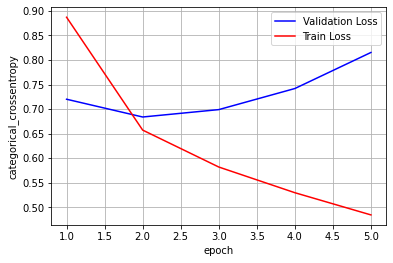

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [138]:
# evaluate model with test set
model_lstm_1layer = keras.models.load_model(COLAB_FILEPATH+'model/LSTM-1layer-3-class-downsampled.h5')

# accuracy on test data
score_1layer = model_lstm_1layer.evaluate(X_test,Y_test_oh, verbose=0)
print('Test loss:', score_1layer[0]) 
print('Test accuracy:', score_1layer[1])

Test loss: 0.47040048241615295
Test accuracy: 0.8197523951530457


In [139]:
# predict rating for the test data
Y_pred_dist_test = model_lstm_1layer.predict(X_test)
Y_pred_test = Y_pred_dist_test.argmax(axis=1)+1
Y_pred_test.shape

(88040,)

In [140]:
# see the unique classes in the ground truth
np.unique(Y_test)

array([-1,  0,  1])

In [141]:
print(np.count_nonzero(Y_test == -1))
print(np.count_nonzero(Y_test == 0))
print(np.count_nonzero(Y_test == 1))

6925
8839
72276


In [142]:
# see the unique classes in the prediction
np.unique(Y_pred_test)

array([1, 2, 3])

In [143]:
print(np.count_nonzero(Y_pred_test == 1))
print(np.count_nonzero(Y_pred_test == 2))
print(np.count_nonzero(Y_pred_test == 3))

5486
9939
72615


In [144]:
len(Y_test) == len(Y_pred_test)

True

In [145]:
# map the prediction class from 1,2,3 to -1,0,1
Y_pred_test = np.where(Y_pred_test == 1, -1, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 2, 0, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 3, 1, Y_pred_test)
np.unique(Y_pred_test)

array([-1,  0,  1])

In [146]:
# F1-score for multi-class classifier
target_names = ['-1', '0', '1']
print(classification_report(Y_test.tolist(), Y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

          -1       0.52      0.41      0.46      6925
           0       0.34      0.39      0.36      8839
           1       0.91      0.91      0.91     72276

    accuracy                           0.82     88040
   macro avg       0.59      0.57      0.58     88040
weighted avg       0.82      0.82      0.82     88040



In [147]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_arr = confusion_matrix(Y_test, Y_pred_test)
cm_arr

array([[ 2850,  1703,  2372],
       [ 1087,  3414,  4338],
       [ 1549,  4822, 65905]])

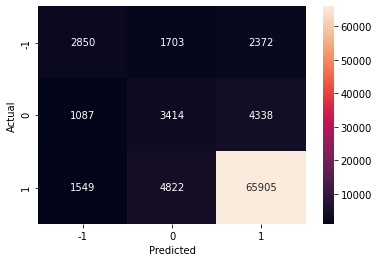

In [148]:
cm_sns = pd.crosstab(Y_test, Y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_sns, annot=True, fmt="d")
plt.show()

In [149]:
Y_pred_test[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [150]:
Y_test.to_numpy()[:20]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Manipulate test label representation
manipulate Y_test and Y_pred_test label into 'a class vs the rest class' BINARY classifier to get a multi-class ROC-AUC

In [151]:
# function to denote the ROC-AUC of a particular class vs the rest (binary problem)
def one_vs_all(pred_list, target):
    final_list_ = []
    for i in pred_list:
        if i == target:
            final_list_.append(1)
        else:
            final_list_.append(0)
    final_list = np.array(final_list_)

    return final_list

In [152]:
# Y_pred_test - positive class vs rest
Y_pred_test_positive = one_vs_all(Y_pred_test, 1)
# Y_test - positive class vs rest
Y_test_positive = one_vs_all(Y_test.to_numpy(), 1)
# Y_pred_test - neutral class vs rest
Y_pred_test_neutral = one_vs_all(Y_pred_test, 0)
# Y_test - neutral class vs rest
Y_test_neutral = one_vs_all(Y_test.to_numpy(), 0)
# Y_pred_test - negative class vs rest
Y_pred_test_negative = one_vs_all(Y_pred_test, -1)
# Y_test - negative class vs rest
Y_test_negative = one_vs_all(Y_test.to_numpy(), -1)

# ROC-AUC - 1 layer LSTM
Receiver operating characteristic curve (ROC)  
Area under the ROC curve (AUC)

In [172]:
# AUC of positive class vs rest
fpr_keras_pos, tpr_keras_pos, thresholds_keras_pos = roc_curve(Y_pred_test_positive, Y_test_positive)
auc_keras_pos = auc(fpr_keras_pos, tpr_keras_pos)
# AUC of neutral class vs rest
fpr_keras_neu, tpr_keras_neu, thresholds_keras_neu = roc_curve(Y_pred_test_neutral, Y_test_neutral)
auc_keras_neu = auc(fpr_keras_neu, tpr_keras_neu)
# AUC of negative class vs rest
fpr_keras_neg, tpr_keras_neg, thresholds_keras_neg = roc_curve(Y_pred_test_negative, Y_test_negative)
auc_keras_neg = auc(fpr_keras_neg, tpr_keras_neg)
# AUC score
auc_keras_pos, auc_keras_neu, auc_keras_neg

(0.7472820276918375, 0.6370169914688586, 0.7350712812632784)

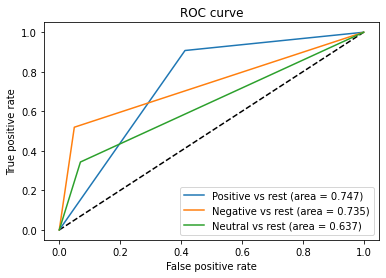

In [173]:
# get the ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_pos, tpr_keras_pos, label='Positive vs rest (area = {:.3f})'.format(auc_keras_pos))
plt.plot(fpr_keras_neg, tpr_keras_neg, label='Negative vs rest (area = {:.3f})'.format(auc_keras_neg))
plt.plot(fpr_keras_neu, tpr_keras_neu, label='Neutral vs rest (area = {:.3f})'.format(auc_keras_neu))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Two LSTM layer 

In [ ]:
vocab_size = len(vocabulary)
embedding_vector_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(128,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           2453248   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          82432     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,667,651
Trainable params: 2,667,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'model/LSTM-2layer-3-class-downsampled.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train_oh, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
140/140 [==============================] - 107s 732ms/step - loss: 0.9742 - accuracy: 0.4718 - val_loss: 0.7504 - val_accuracy: 0.6658

Epoch 00001: val_loss improved from inf to 0.75040, saving model to ./drive/My Drive/4034-amazon-review-classification-new/model/LSTM-2layer-3-class-downsampled.h5
Epoch 2/5
140/140 [==============================] - 102s 728ms/step - loss: 0.6871 - accuracy: 0.6974 - val_loss: 0.6966 - val_accuracy: 0.6973

Epoch 00002: val_loss improved from 0.75040 to 0.69658, saving model to ./drive/My Drive/4034-amazon-review-classification-new/model/LSTM-2layer-3-class-downsampled.h5
Epoch 3/5
140/140 [==============================] - 103s 735ms/step - loss: 0.5984 - accuracy: 0.7477 - val_loss: 0.7006 - val_accuracy: 0.6916

Epoch 00003: val_loss did not improve from 0.69658
Epoch 4/5
140/140 [==============================] - 103s 733ms/step - loss: 0.5559 - accuracy: 0.7687 - val_loss: 0.7209 - val_accuracy: 0.6906

Epoch 00004: val_loss did not imp

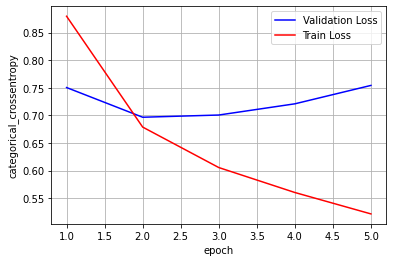

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [174]:
# evaluate model with test set
model_lstm_2layer = keras.models.load_model(COLAB_FILEPATH+'model/LSTM-2layer-3-class-downsampled.h5')

# accuracy on test data
score_2layer = model_lstm_2layer.evaluate(X_test,Y_test_oh, verbose=0)
print('Test loss:', score_2layer[0]) 
print('Test accuracy:', score_2layer[1])

Test loss: 0.5162888169288635
Test accuracy: 0.7974329590797424


In [175]:
# predict rating for the test data
Y_pred_dist_test = model_lstm_2layer.predict(X_test)
Y_pred_test = Y_pred_dist_test.argmax(axis=1)+1
Y_pred_test.shape

(88040,)

In [176]:
# see the unique classes in the prediction
np.unique(Y_pred_test)

array([1, 2, 3])

In [177]:
# map the prediction class from 1,2,3 to -1,0,1
Y_pred_test = np.where(Y_pred_test == 1, -1, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 2, 0, Y_pred_test)
Y_pred_test = np.where(Y_pred_test == 3, 1, Y_pred_test)
np.unique(Y_pred_test)

array([-1,  0,  1])

In [178]:
# F1-score for multi-class classifier
target_names = ['-1', '0', '1']
print(classification_report(Y_test.tolist(), Y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

          -1       0.49      0.45      0.47      6925
           0       0.30      0.45      0.36      8839
           1       0.92      0.87      0.90     72276

    accuracy                           0.80     88040
   macro avg       0.57      0.59      0.57     88040
weighted avg       0.82      0.80      0.81     88040



In [179]:
# confusion matrix
cm_arr = confusion_matrix(Y_test, Y_pred_test)
cm_arr

array([[ 3091,  2037,  1797],
       [ 1240,  3963,  3636],
       [ 2014,  7112, 63150]])

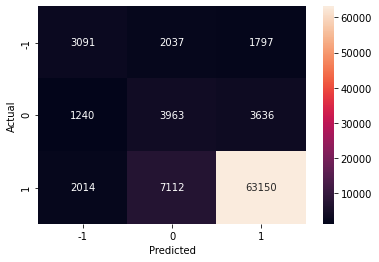

In [180]:
cm_sns = pd.crosstab(Y_test, Y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm_sns, annot=True, fmt="d")
plt.show()

### Manipulate test label representation
manipulate Y_test and Y_pred_test label into 'a class vs the rest class' BINARY classifier to get a multi-class ROC-AUC

In [181]:
# Y_pred_test - positive class vs rest
Y_pred_test_positive = one_vs_all(Y_pred_test, 1)
# Y_test - positive class vs rest
Y_test_positive = one_vs_all(Y_test.to_numpy(), 1)
# Y_pred_test - neutral class vs rest
Y_pred_test_neutral = one_vs_all(Y_pred_test, 0)
# Y_test - neutral class vs rest
Y_test_neutral = one_vs_all(Y_test.to_numpy(), 0)
# Y_pred_test - negative class vs rest
Y_pred_test_negative = one_vs_all(Y_pred_test, -1)
# Y_test - negative class vs rest
Y_test_negative = one_vs_all(Y_test.to_numpy(), -1)

# ROC-AUC - 2 layer LSTM

Receiver operating characteristic curve (ROC)  
Area under the ROC curve (AUC)

In [182]:
# AUC of positive class vs rest
fpr_keras_pos, tpr_keras_pos, thresholds_keras_pos = roc_curve(Y_pred_test_positive, Y_test_positive)
auc_keras_pos = auc(fpr_keras_pos, tpr_keras_pos)
# AUC of neutral class vs rest
fpr_keras_neu, tpr_keras_neu, thresholds_keras_neu = roc_curve(Y_pred_test_neutral, Y_test_neutral)
auc_keras_neu = auc(fpr_keras_neu, tpr_keras_neu)
# AUC of negative class vs rest
fpr_keras_neg, tpr_keras_neg, thresholds_keras_neg = roc_curve(Y_pred_test_negative, Y_test_negative)
auc_keras_neg = auc(fpr_keras_neg, tpr_keras_neg)
# AUC score
auc_keras_pos, auc_keras_neu, auc_keras_neg

(0.7258739186479966, 0.6185832073795928, 0.7201122918178964)

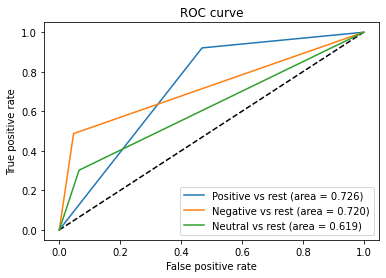

In [185]:
# get the ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_pos, tpr_keras_pos, label='Positive vs rest (area = {:.3f})'.format(auc_keras_pos))
plt.plot(fpr_keras_neg, tpr_keras_neg, label='Negative vs rest (area = {:.3f})'.format(auc_keras_neg))
plt.plot(fpr_keras_neu, tpr_keras_neu, label='Neutral vs rest (area = {:.3f})'.format(auc_keras_neu))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()